In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from data_utils import *
from datasets import *
from sklearn.metrics import mean_squared_error

############################# Place the games here ############################
train_game_names = ['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']
test_game_names = ['Kawaii_House', 'Kawaii_Daycare']
val_game_names = ['Kawaii_House', 'Kawaii_Daycare']

In [2]:
######################### Place files for splits ##################################
######################### Must be similar to csv of predicted values ##################################
train_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/train.txt")
val_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/val.txt")
test_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/test.txt")

col_pred = ["thumbstick_left_x", "thumbstick_left_y", "thumbstick_right_x", "thumbstick_right_y", "head_pos_x", "head_pos_y", "head_pos_z", "head_dir_a", "head_dir_b", "head_dir_c", "head_dir_d"]

train_set = MultiGameDataset(train_game_names, train_sessions, cols_to_predict=col_pred)
val_set = MultiGameDataset(val_game_names, val_sessions, cols_to_predict=col_pred)
test_set = MultiGameDataset(test_game_names, test_sessions, cols_to_predict=col_pred) 

# Normalisation
thumbsticks_loc = 6
head_pos_loc = 9

train_set.df[train_set.df.columns[2:thumbsticks_loc]] = (train_set.df[train_set.df.columns[2:thumbsticks_loc]] + 1) / 2
val_set.df[val_set.df.columns[2:thumbsticks_loc]] = (val_set.df[val_set.df.columns[2:thumbsticks_loc]] + 1) / 2
test_set.df[test_set.df.columns[2:thumbsticks_loc]] = (test_set.df[test_set.df.columns[2:thumbsticks_loc]] + 1) / 2

train_set.df[train_set.df.columns[thumbsticks_loc:head_pos_loc]] = (train_set.df[train_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
val_set.df[val_set.df.columns[thumbsticks_loc:head_pos_loc]] = (val_set.df[val_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
test_set.df[test_set.df.columns[thumbsticks_loc:head_pos_loc]] = (test_set.df[test_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4

train_set.df[train_set.df.columns[head_pos_loc:]] = (train_set.df[train_set.df.columns[head_pos_loc:]] + 1) / 2
val_set.df[val_set.df.columns[head_pos_loc:]] = (val_set.df[val_set.df.columns[head_pos_loc:]] + 1) / 2
test_set.df[test_set.df.columns[head_pos_loc:]] = (test_set.df[test_set.df.columns[head_pos_loc:]] + 1) / 2

In [3]:
########################## File of csv predictions ##################################

pred_df = pd.read_csv("/data/mala711/COMPSCI715/CNNRNN/csv_files/GRU_CPCA_train_['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']_test_['Kawaii_House', 'Kawaii_Daycare']_init_test_seq_size_50_seqstart_20_iter_10_reg_1e-05_lr_0.01_dropout_0.2_weighting_True.csv")
gail_df = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/GAILv2_GRU_train_['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']_test_['Kawaii_House', 'Kawaii_Daycare']_ppoepochs_10_mini_batch_10_lr_0.03_dlr_0.003_init_test_seq_size_50_iter_10_dropout_0.4_weightd_0.005.csv")
vtra_df = pd.read_csv("/data/mala711/COMPSCI715/ViT/csvs/vivit_preds.csv")
resn_df = pd.read_csv("/data/mala711/COMPSCI715/transfer-learning/csv_files/resnet50_prediction_20241004.csv")
resL_df = pd.read_csv("/data/mala711/COMPSCI715/transfer-learning/csv_files/ResNet-LSTM-normalized_data.csv")

In [4]:
resn_df[resn_df.columns[2:thumbsticks_loc]] = (resn_df[resn_df.columns[2:thumbsticks_loc]] + 1) / 2
resn_df[resn_df.columns[thumbsticks_loc:head_pos_loc]] = (resn_df[resn_df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
resn_df[resn_df.columns[head_pos_loc:]] = (resn_df[resn_df.columns[head_pos_loc:]] + 1) / 2

In [5]:
true_df = test_set.df

# Create ids for to filter rows
pred_df['full_name'] = pred_df['game_session'] + pred_df['frame'].astype(str)
gail_df['full_name'] = gail_df['game_session'] + gail_df['frame'].astype(str)
vtra_df['full_name'] = vtra_df['game_session'] + vtra_df['frame'].astype(str)
resn_df['full_name'] = resn_df['game_session'] + resn_df['frame'].astype(str)
resL_df['full_name'] = resL_df['game_session'] + resL_df['frame'].astype(str)
true_df['full_name'] = true_df['game_session'] + true_df['frame'].astype(str)

mask = true_df['full_name'].isin(pred_df['full_name'])
filtered_df = true_df[mask]

mask = vtra_df['full_name'].isin(pred_df['full_name'])
vitransf_df = vtra_df[mask]

mask = resn_df['full_name'].isin(pred_df['full_name'])
resnetfi_df = resn_df[mask]

mask = resL_df['full_name'].isin(pred_df['full_name'])
resnetLS_df = resL_df[mask]

fin_true_df = filtered_df.sort_values(by = ['game_session', 'frame'])
fin_true_df = fin_true_df.reset_index(drop='index')

fin_pred_df = pred_df.sort_values(by = ['game_session', 'frame'])
fin_pred_df = fin_pred_df.reset_index(drop='index')

fin_gail_df = gail_df.sort_values(by = ['game_session', 'frame'])
fin_gail_df = fin_gail_df.reset_index(drop='index')

fin_vtra_df = vitransf_df.sort_values(by = ['game_session', 'frame'])
fin_vtra_df = fin_vtra_df.reset_index(drop='index')

fin_resn_df = resnetfi_df.sort_values(by = ['game_session', 'frame'])
fin_resn_df = fin_resn_df.reset_index(drop='index')

fin_resL_df = resnetLS_df.sort_values(by = ['game_session', 'frame'])
fin_resL_df = fin_resL_df.reset_index(drop='index')

# Get matrices for prediction
pred_mat = fin_pred_df.iloc[:, 2:-1].to_numpy()
true_mat = fin_true_df.iloc[:, 2:-1].to_numpy()
gail_mat = fin_gail_df.iloc[:, 2:-1].to_numpy()
vtra_mat = fin_vtra_df.iloc[:, 2:-1].to_numpy()
resn_mat = fin_resn_df.iloc[:, 2:-1].to_numpy()
resL_mat = fin_resL_df.iloc[:, 2:-1].to_numpy()

In [6]:
###################### Calculate MSE for control ######################
for i in range(11):
    mse = mean_squared_error(true_mat[:, i], pred_mat[:, i])
    c = i+2
    print(f'{fin_pred_df.columns[c]}: {mse}')

mean_squared_error(true_mat, pred_mat)

thumbstick_left_x: 0.020185859898394356
thumbstick_left_y: 0.13581040992267146
thumbstick_right_x: 0.003464585516024306
thumbstick_right_y: 0.0029046281251290827
head_pos_x: 0.012286956539777807
head_pos_y: 0.000442257758817895
head_pos_z: 0.004900525786956065
head_dir_a: 0.005515067151291351
head_dir_b: 0.05037971978902581
head_dir_c: 0.0008550253319451775
head_dir_d: 0.0045691611663612915


0.021937654271490418

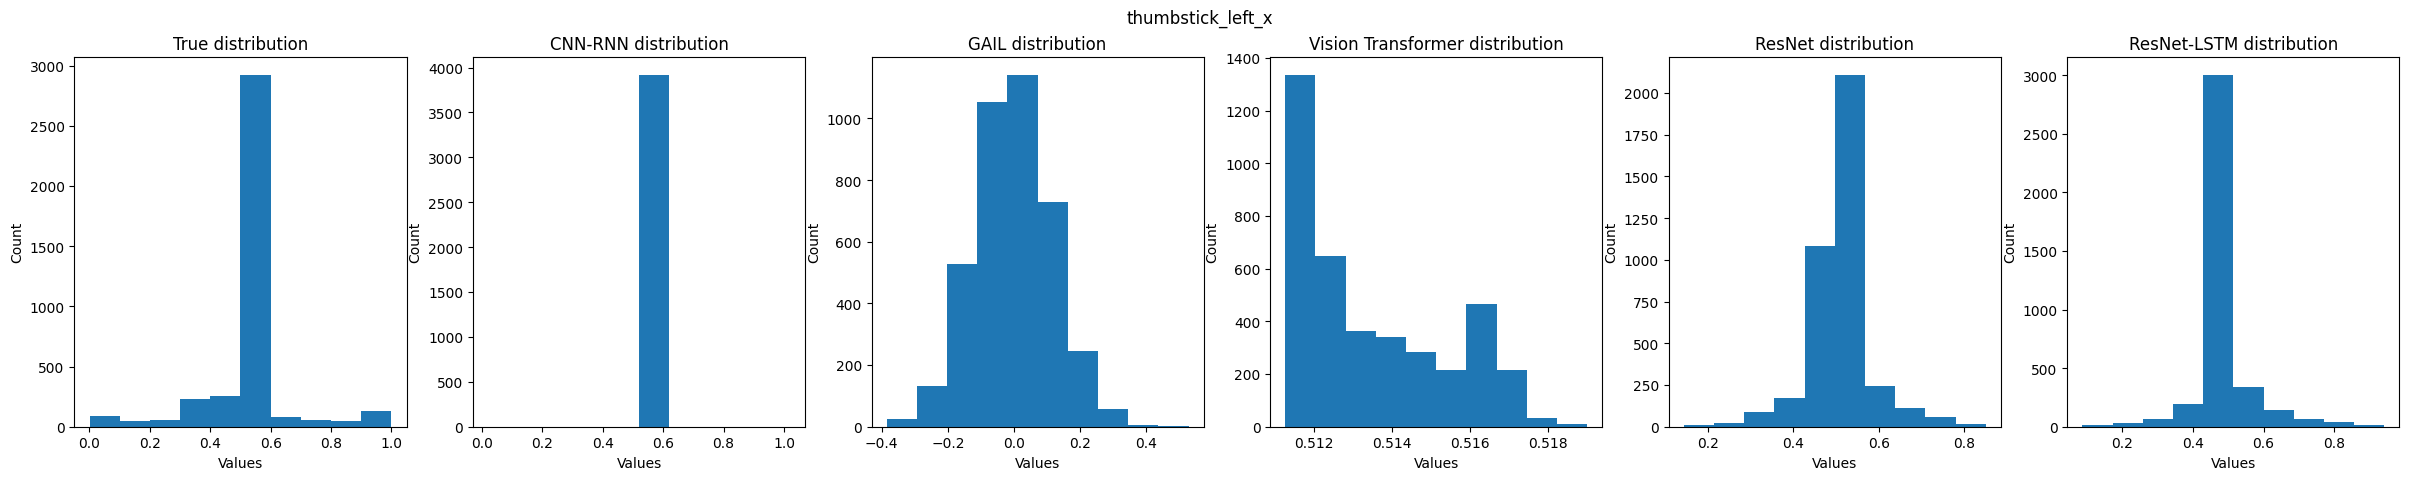

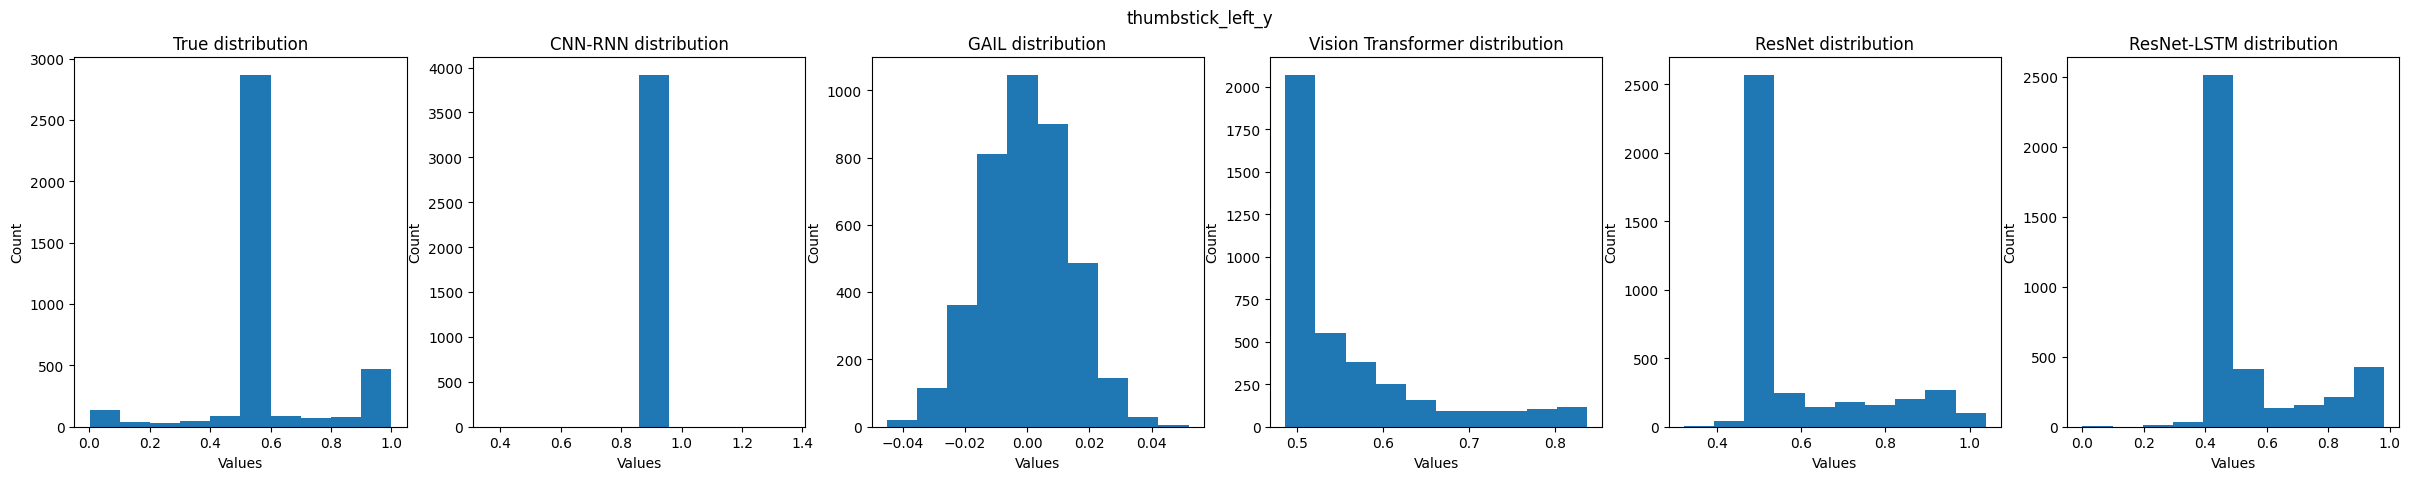

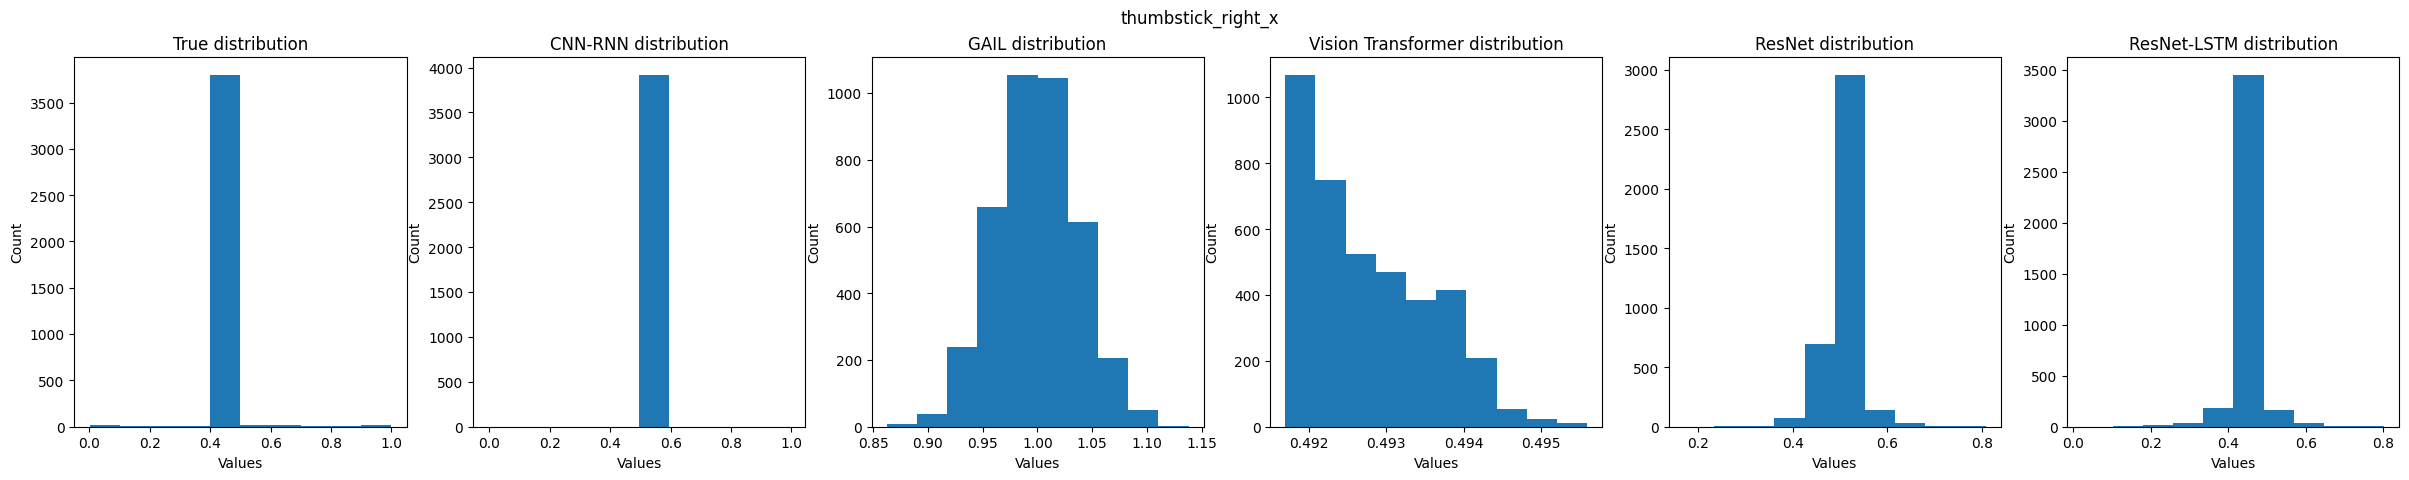

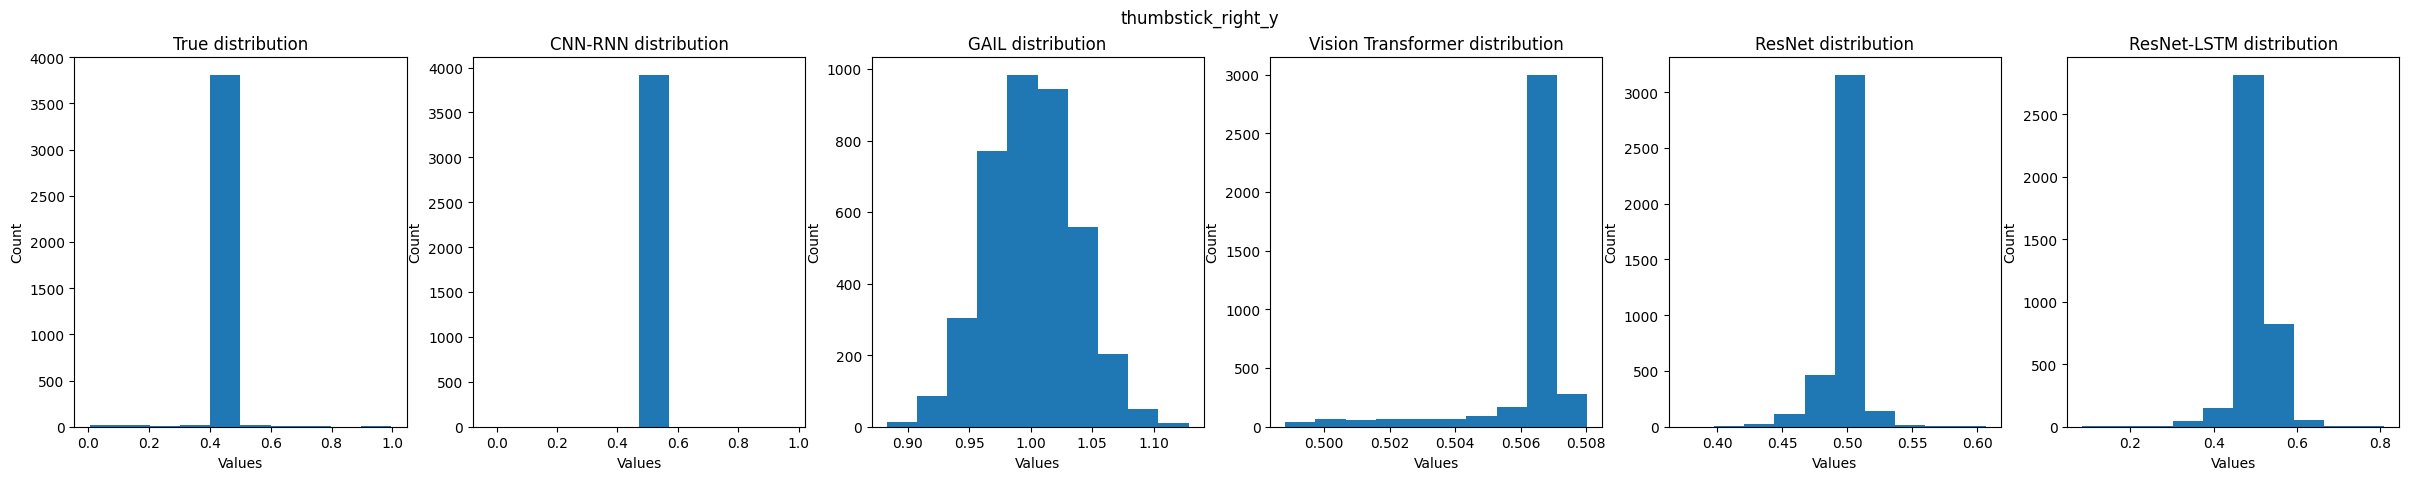

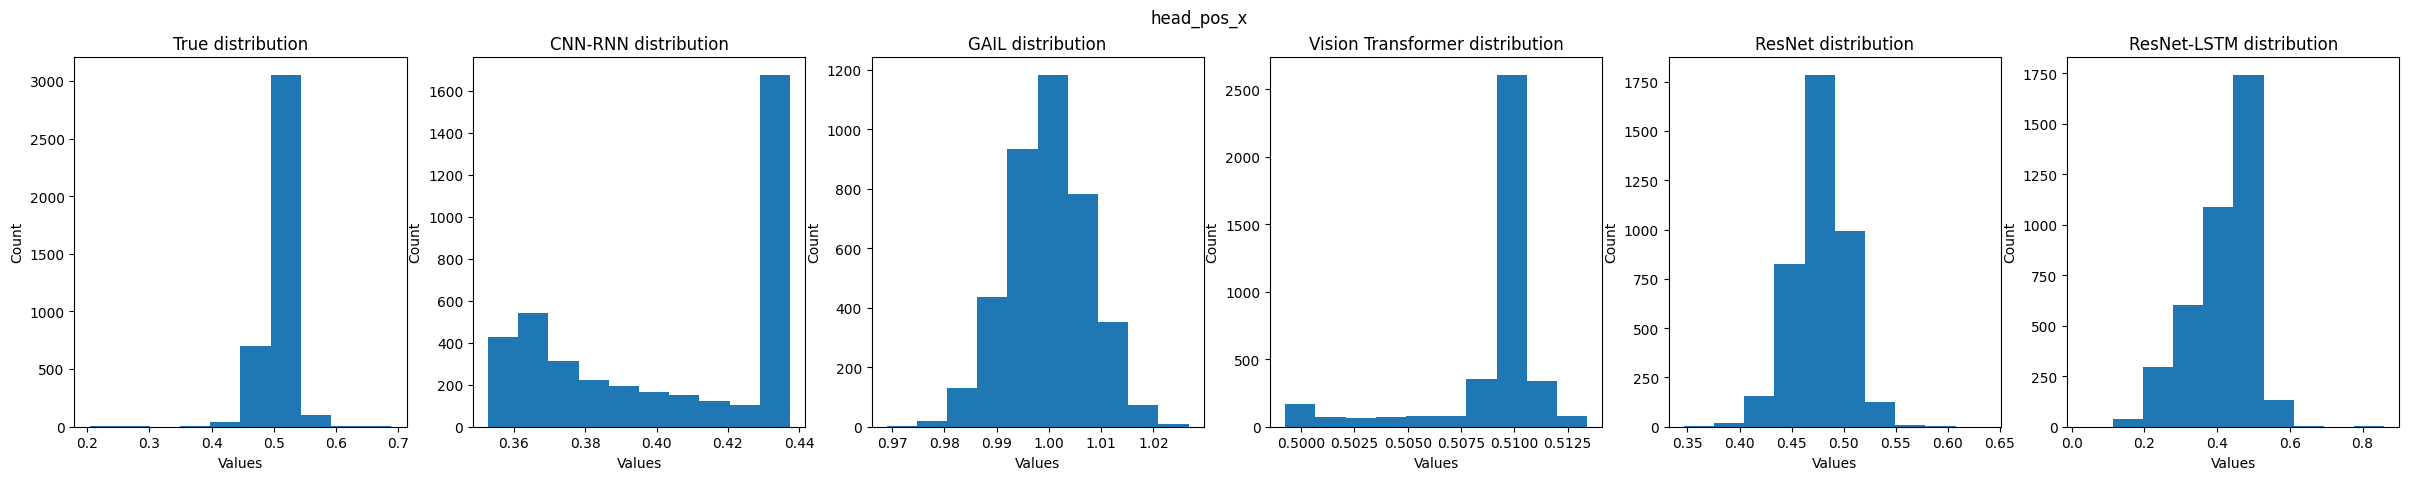

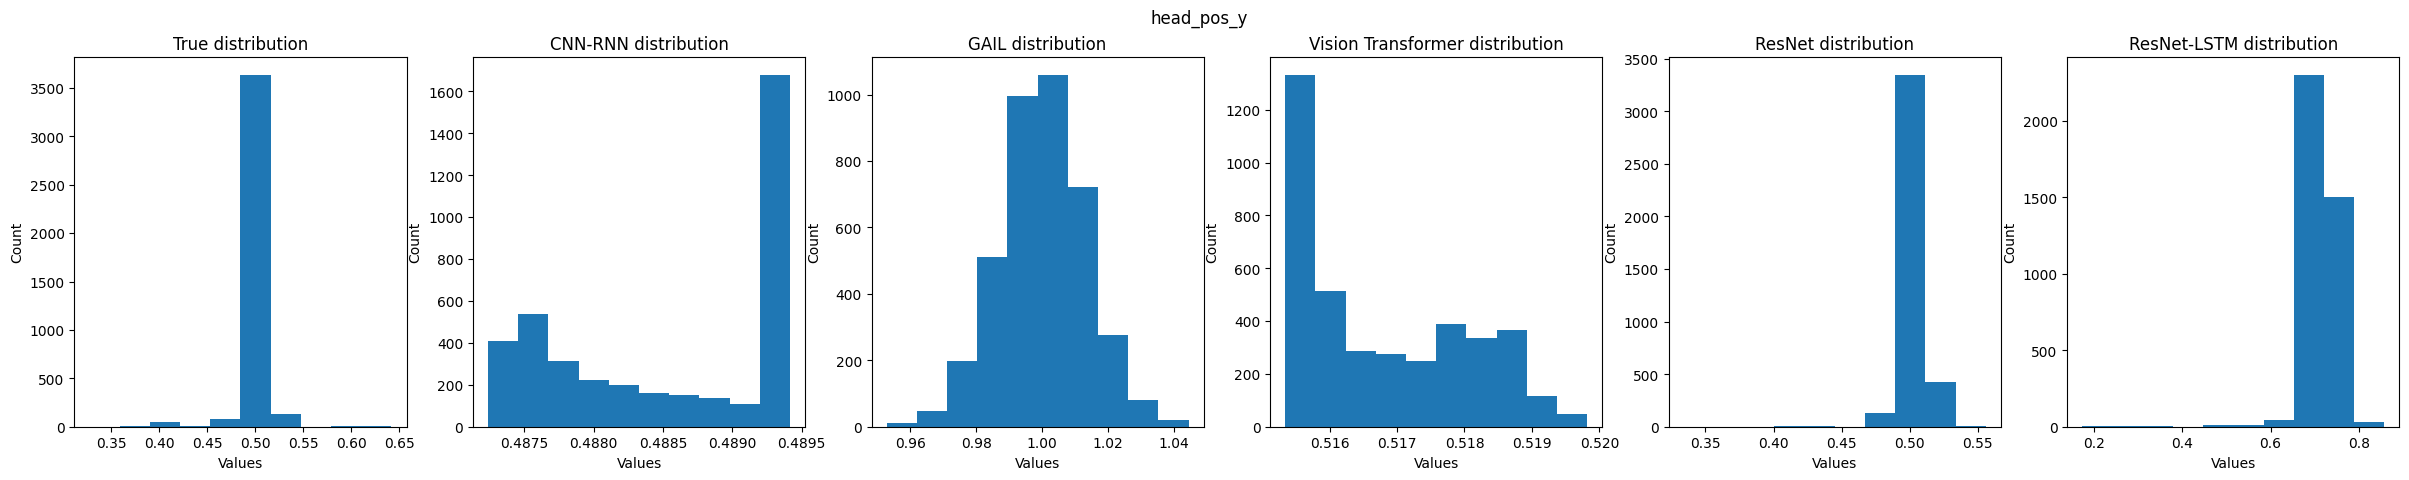

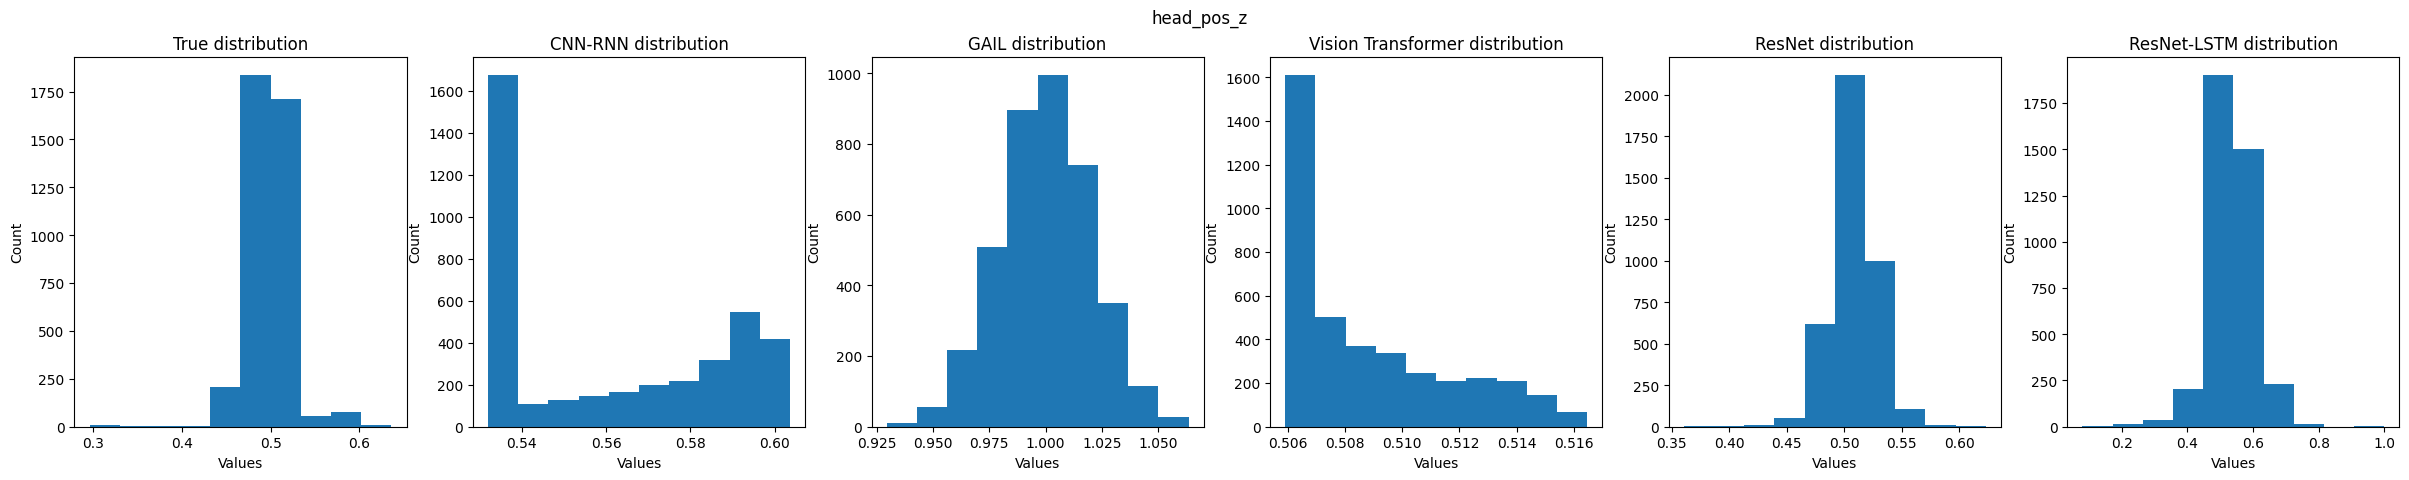

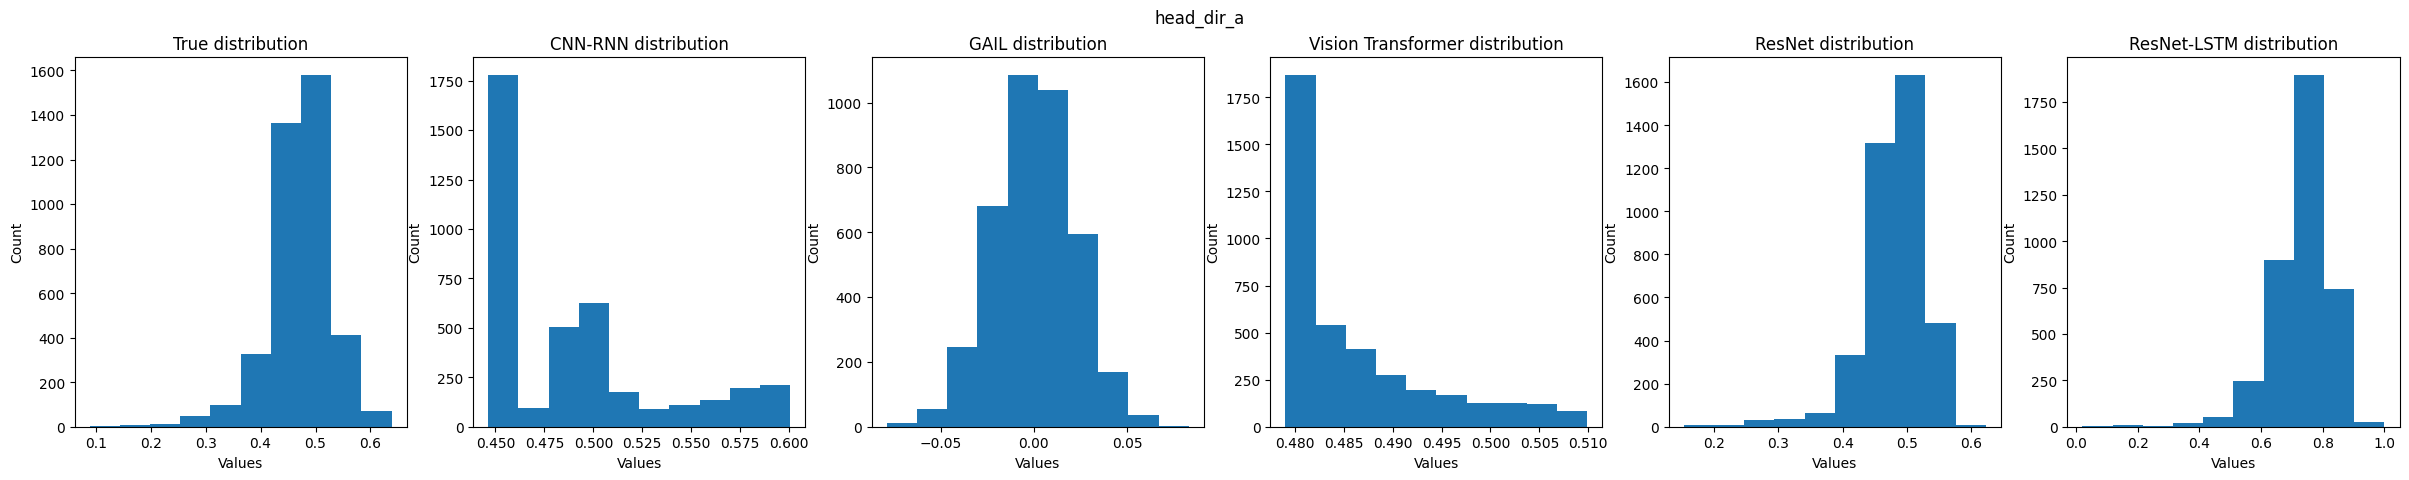

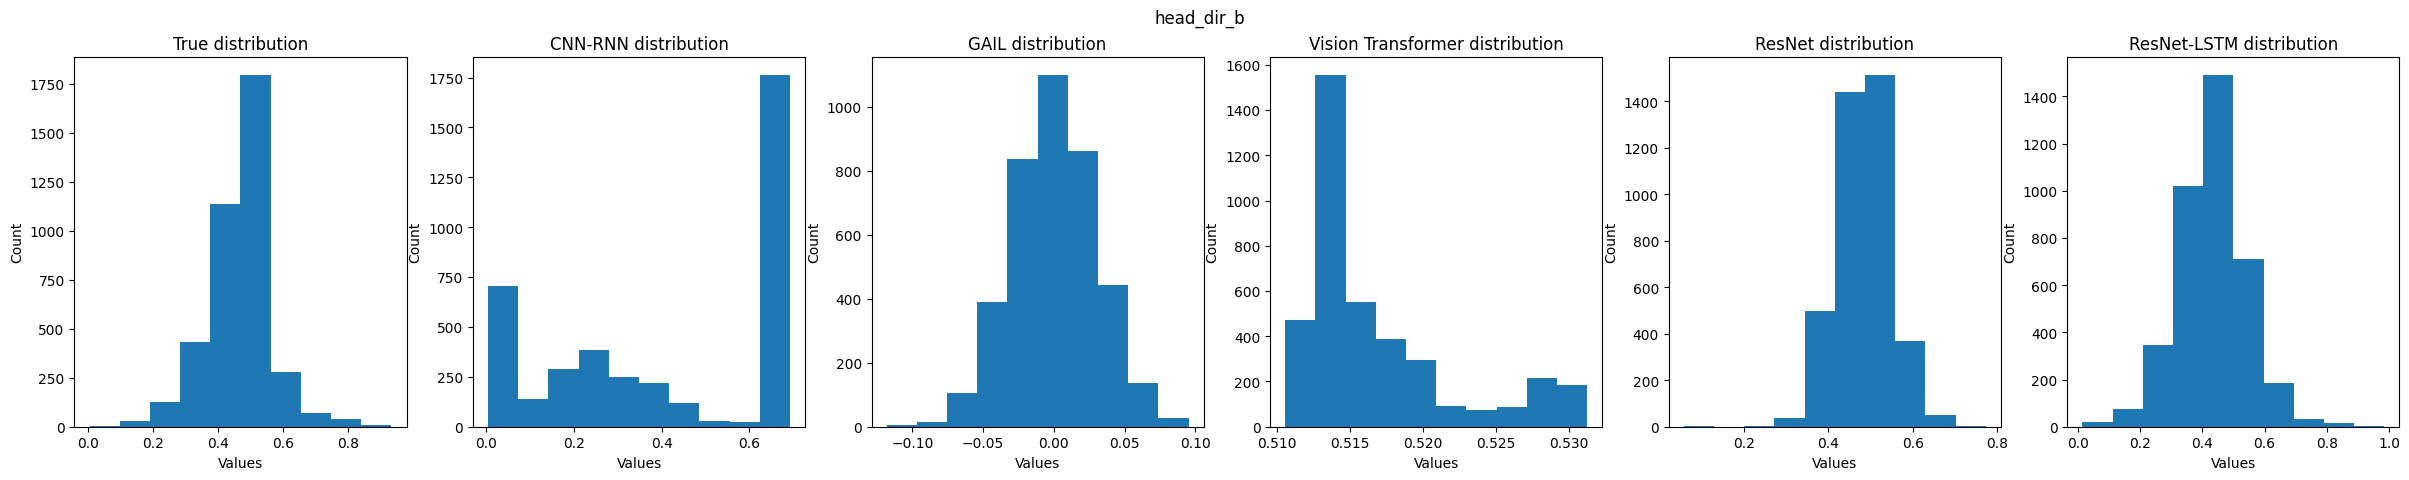

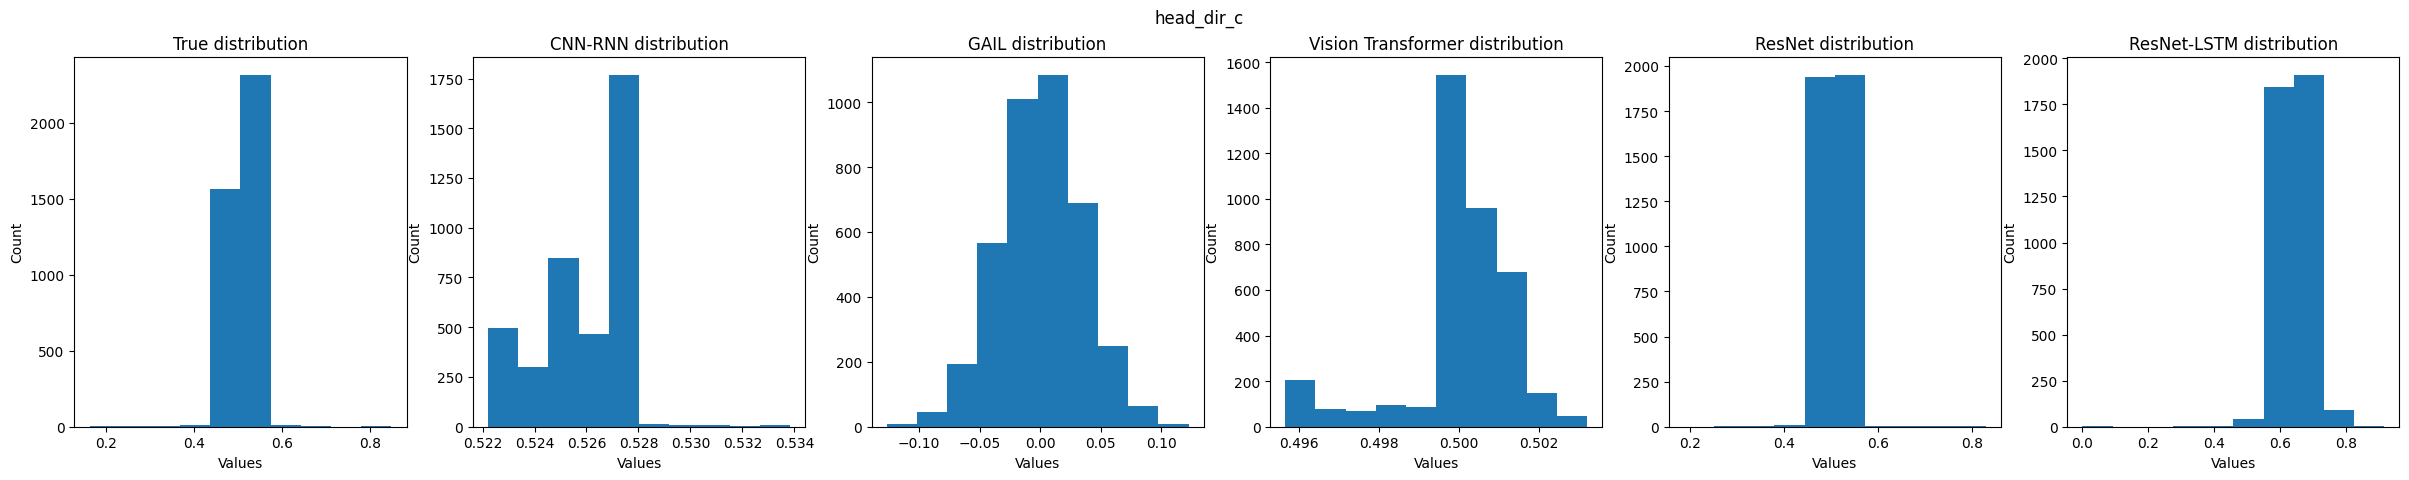

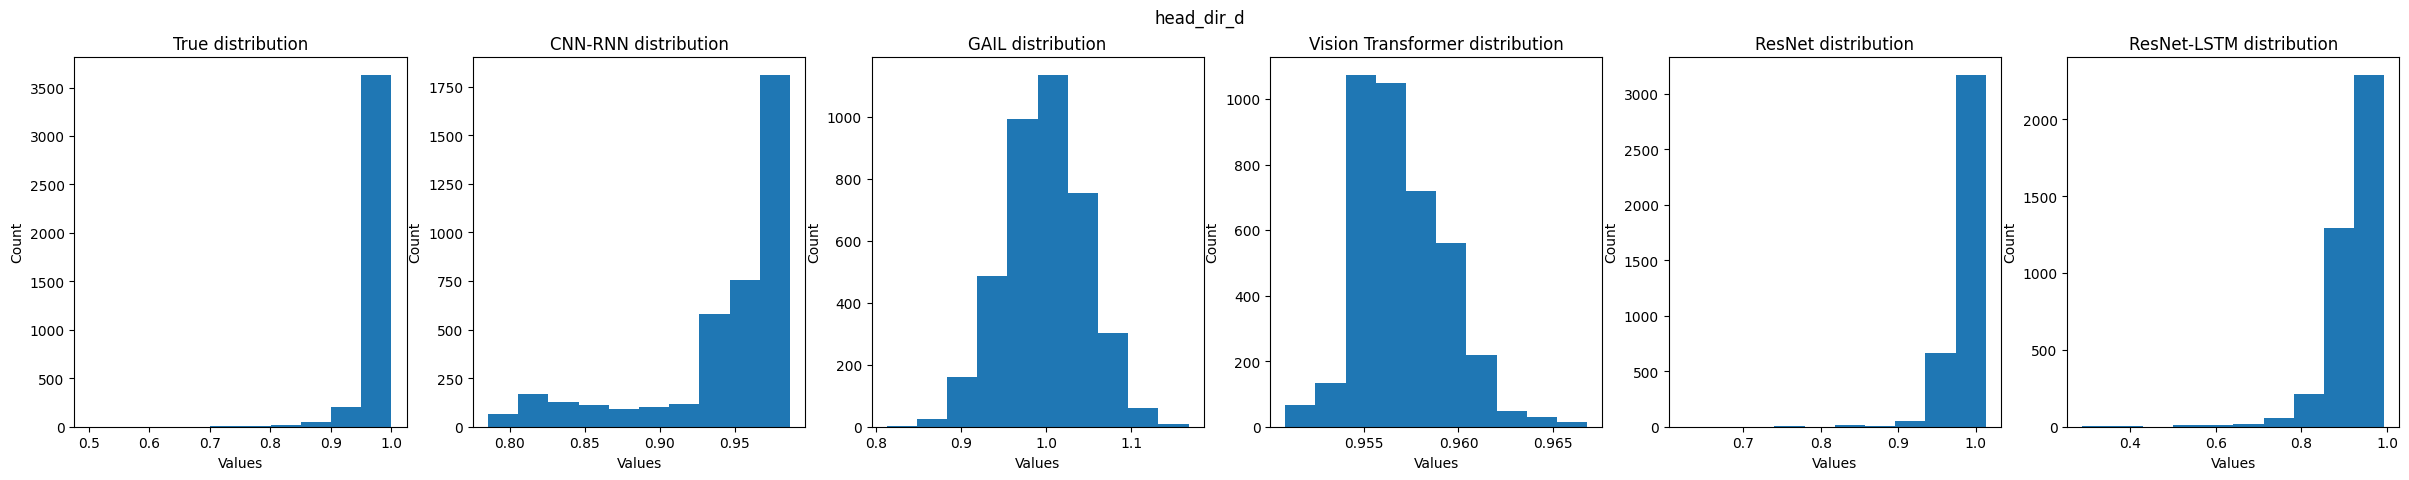

In [7]:
###################### Visualise distributions of each control ######################
import matplotlib.gridspec as gridspec

true_dist = fin_true_df.iloc[:, 2:]
pred_dist = fin_pred_df.iloc[:, 2:]
gail_dist = fin_gail_df.iloc[:, 2:]
vtra_dist = fin_vtra_df.iloc[:, 2:]
resn_dist = fin_resn_df.iloc[:, 2:]
resL_dist = fin_resL_df.iloc[:, 2:]

for i in range(11):
    fig, axs = plt.subplots(nrows=1, ncols=6)
    fig.set_figwidth(30)
    fig.suptitle(col_pred[i])

    axs[0].hist(true_dist.iloc[:, i])
    axs[0].set_title('True distribution')
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel('Values')

    axs[1].hist(pred_dist.iloc[:, i])
    axs[1].set_title('CNN-RNN distribution')
    axs[1].set_ylabel('Count')
    axs[1].set_xlabel('Values')

    axs[2].hist(gail_dist.iloc[:, i])
    axs[2].set_title('GAIL distribution')
    axs[2].set_ylabel('Count')
    axs[2].set_xlabel('Values')

    axs[3].hist(vtra_dist.iloc[:, i])
    axs[3].set_title('Vision Transformer distribution')
    axs[3].set_ylabel('Count')
    axs[3].set_xlabel('Values')

    axs[4].hist(resn_dist.iloc[:, i])
    axs[4].set_title('ResNet distribution')
    axs[4].set_ylabel('Count')
    axs[4].set_xlabel('Values')

    axs[5].hist(resL_dist.iloc[:, i])
    axs[5].set_title('ResNet-LSTM distribution')
    axs[5].set_ylabel('Count')
    axs[5].set_xlabel('Values')

plt.show()

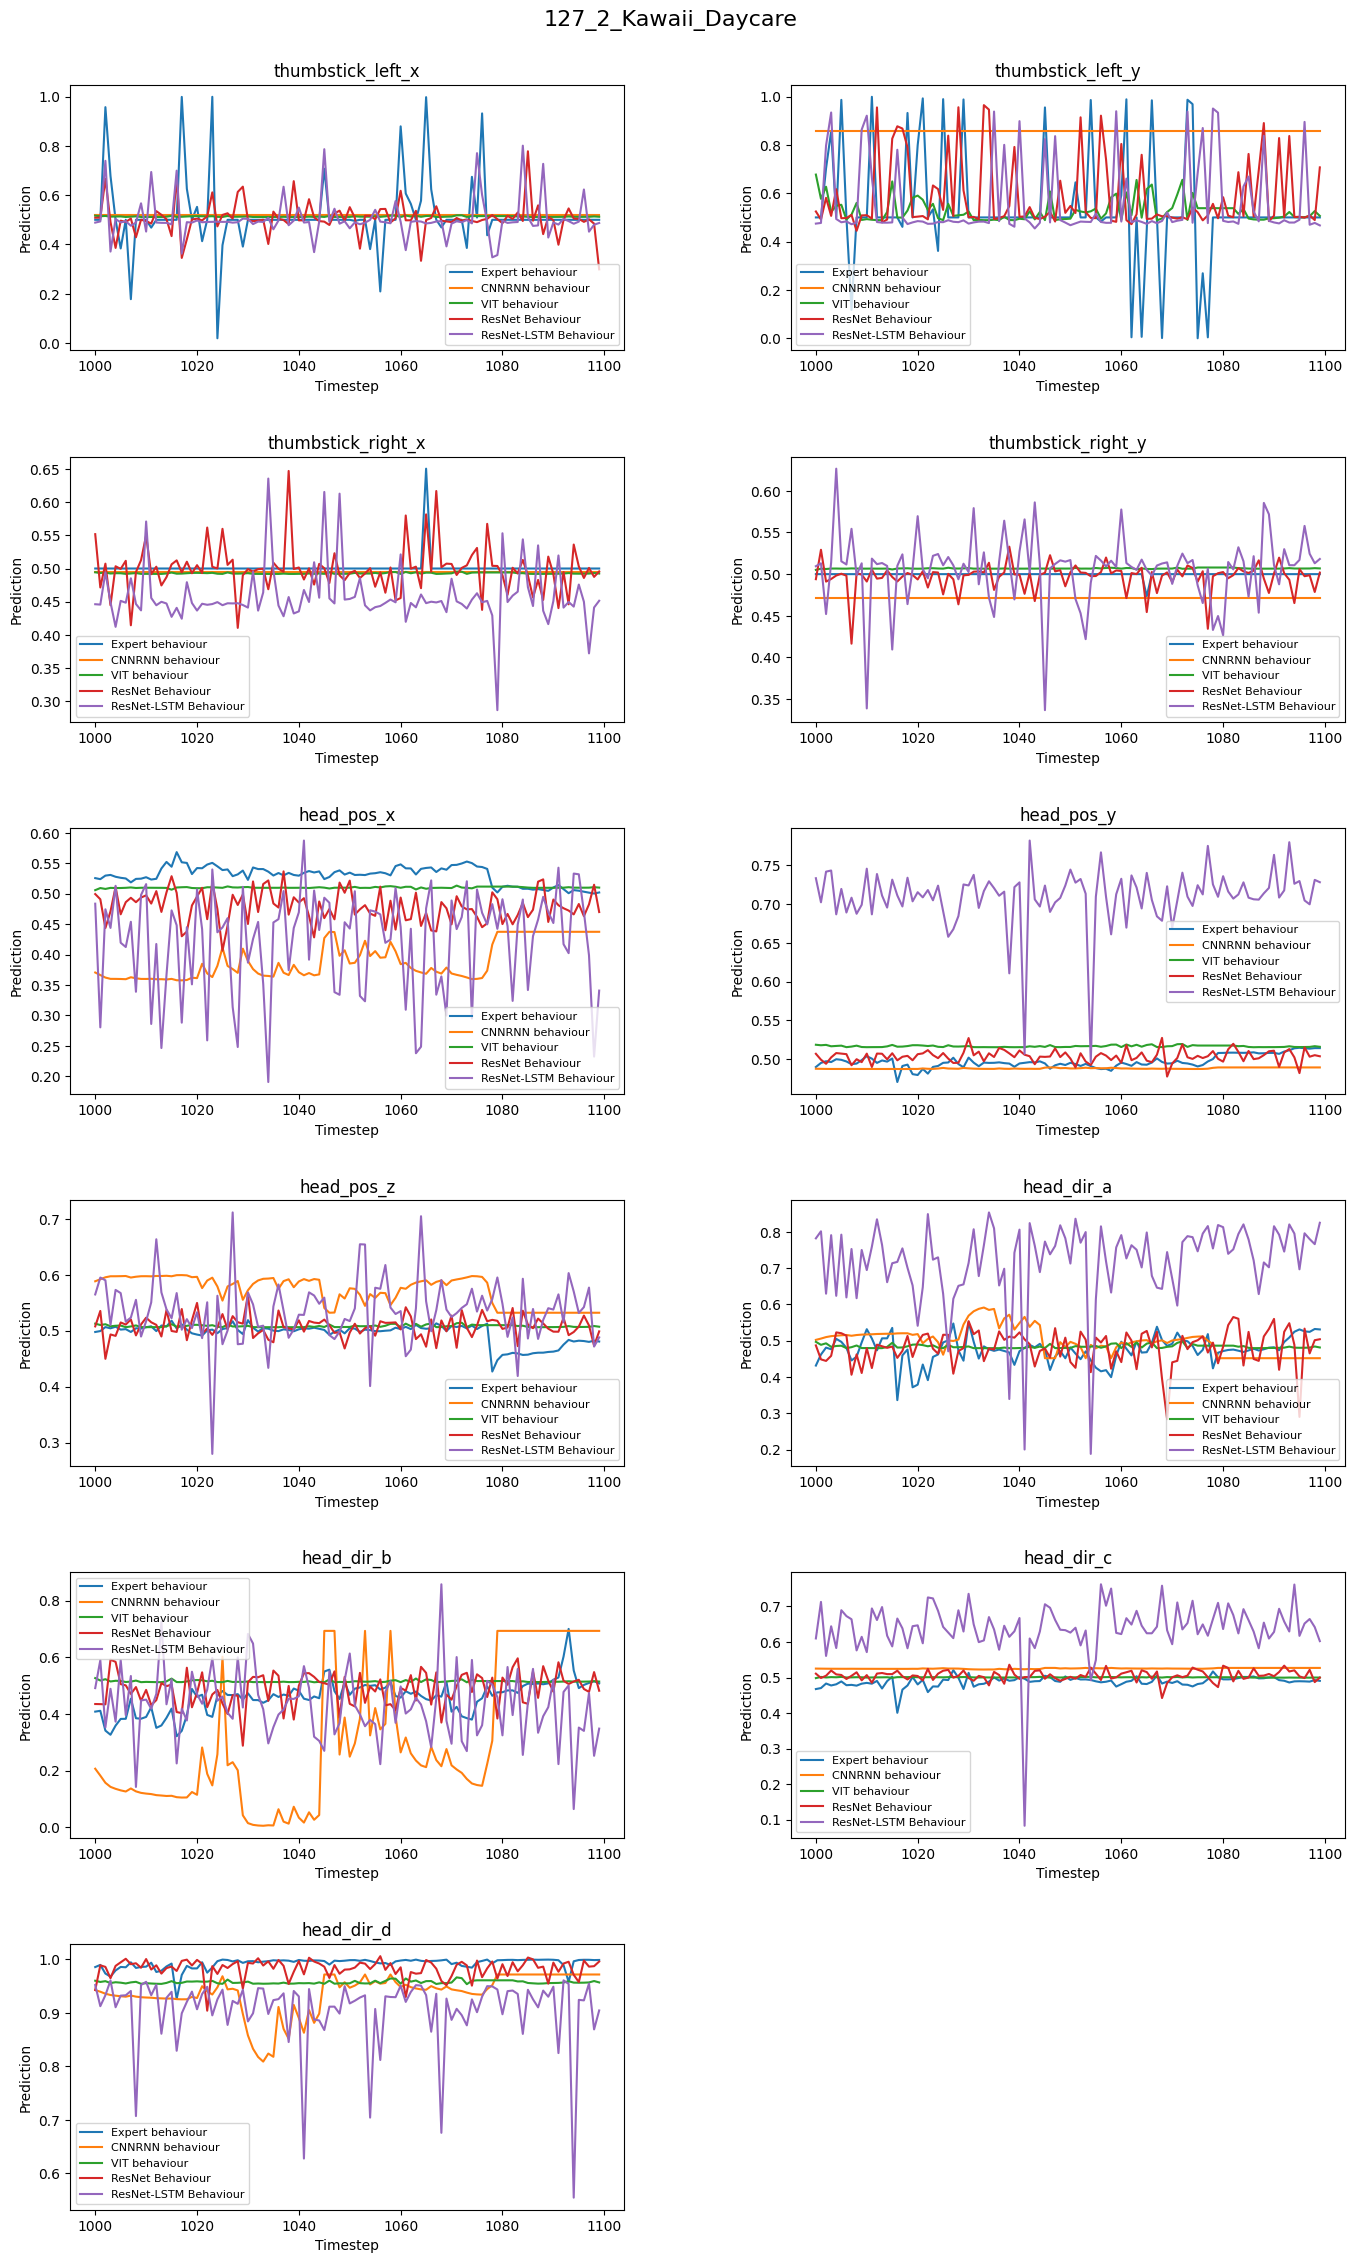

In [25]:
###################### Visualise behaviour given a sequence ######################
seq_inds = [0, 10, 25, 30]
seq_ind = seq_inds[1]
seq_length = 100

true_seq = fin_true_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
pred_seq = fin_pred_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
gail_seq = fin_gail_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
vtra_seq = fin_vtra_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
resn_seq = fin_resn_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
resL_seq = fin_resL_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]

title = fin_true_df.iloc[seq_length*seq_ind, 0:2]

fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(25)
fig.set_figwidth(15)
fig.delaxes(axs[5,1])
fig.suptitle(title.iloc[0], size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(axs.flat):
    if i == 11:
        break
    ax.plot(true_seq.iloc[:, i])
    ax.plot(pred_seq.iloc[:, i])
    #ax.plot(gail_seq.iloc[:, i])
    ax.plot(vtra_seq.iloc[:, i])
    ax.plot(resn_seq.iloc[:, i])
    ax.plot(resL_seq.iloc[:, i])
    ax.set_title(col_pred[i])
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Prediction')
    # ax.legend(['Expert behaviour', 'CNNRNN behaviour', 'GAIL behaviour', 'VIT behaviour', 'ResNet Behaviour'])
    ax.legend(['Expert behaviour', 'CNNRNN behaviour', 'VIT behaviour', 'ResNet Behaviour', 'ResNet-LSTM Behaviour'], fontsize=8)
    

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

In [15]:
test_disc = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/test_disc_loss.csv")
train_disc = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/train_dsc.csv")
train_ppo = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/train_ppo.csv")

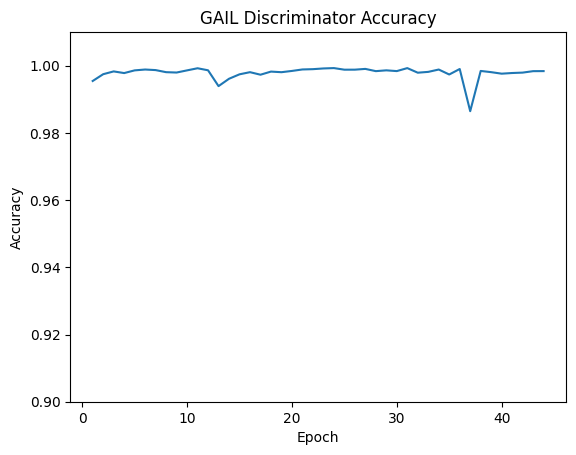

In [35]:
plt.plot(test_disc['Step'], 1-test_disc['Value'])
plt.ylim(0.90, 1.01)
plt.title('GAIL Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

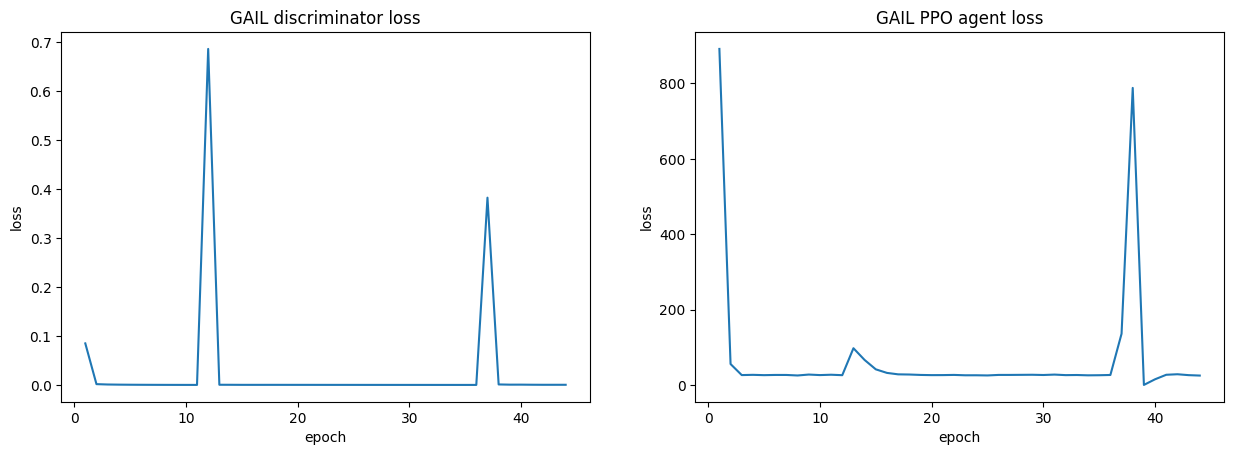

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
axs[0].plot(train_disc['Step'], train_disc['Value'])
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('GAIL discriminator loss')
axs[1].plot(train_ppo['Step'], train_ppo['Value'])
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].set_title('GAIL PPO agent loss')
plt.show()

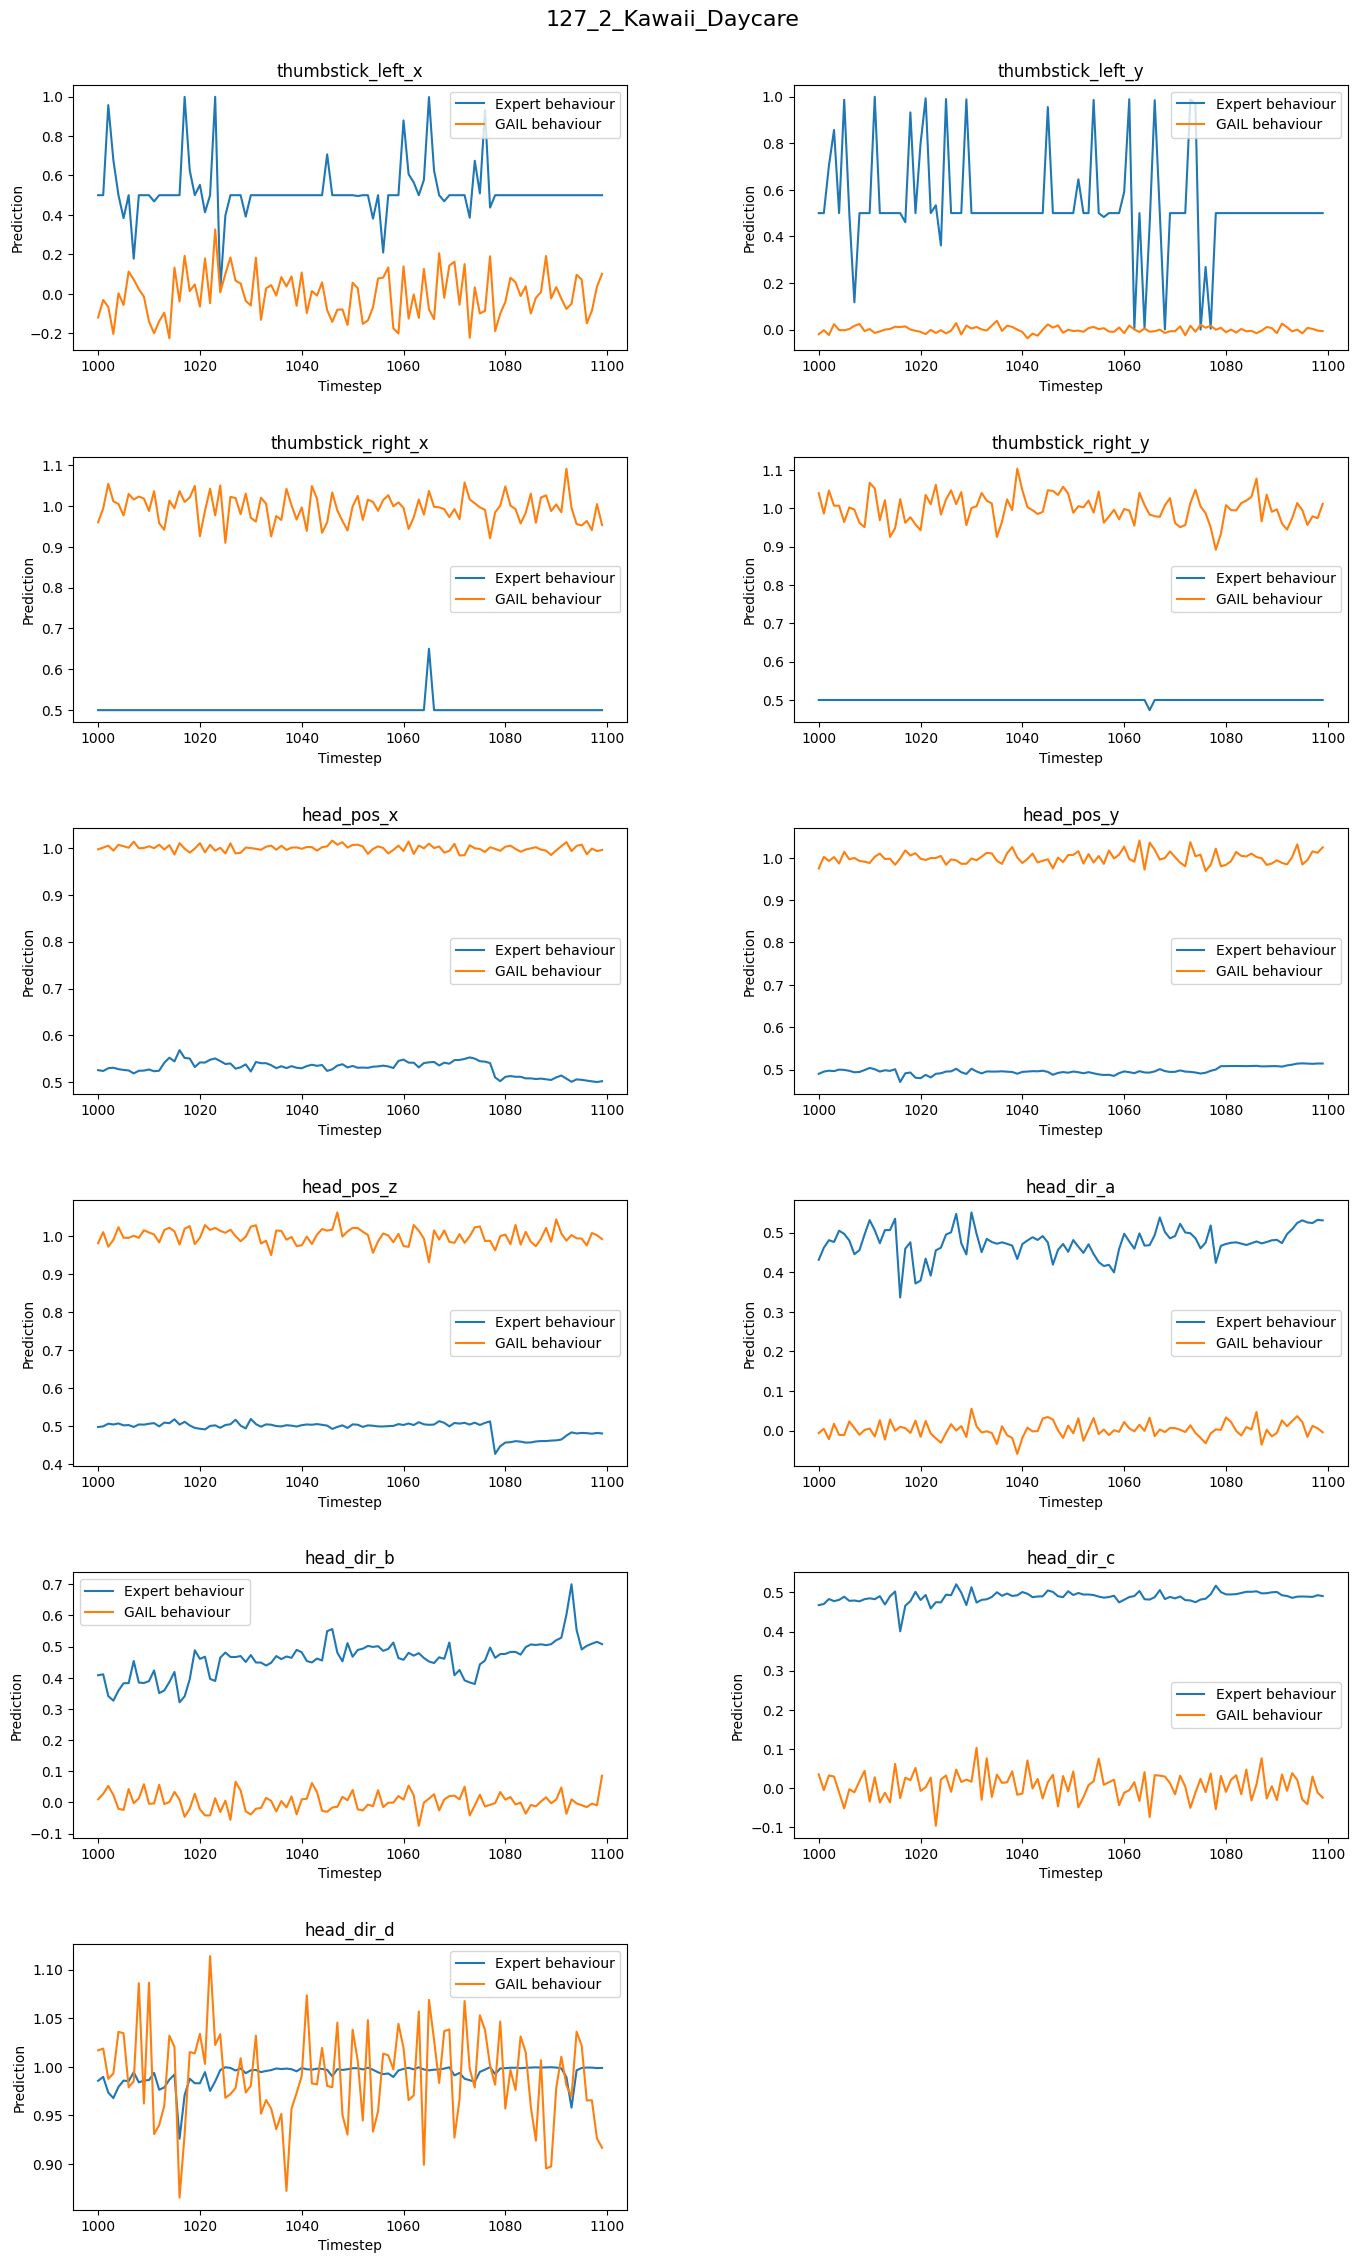

In [19]:
###################### Visualise behaviour given a sequence ######################
seq_ind = 10
seq_length = 100

true_seq = fin_true_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
pred_seq = fin_pred_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
gail_seq = fin_gail_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
vtra_seq = fin_vtra_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
resn_seq = fin_resn_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]


title = fin_true_df.iloc[seq_length*seq_ind, 0:2]

fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(25)
fig.set_figwidth(15)
fig.delaxes(axs[5,1])
fig.suptitle(title.iloc[0], size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(axs.flat):
    if i == 11:
        break
    ax.plot(true_seq.iloc[:, i])
    ax.plot(gail_seq.iloc[:, i])
    ax.set_title(col_pred[i])
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Prediction')
    # ax.legend(['Expert behaviour', 'CNNRNN behaviour', 'GAIL behaviour', 'VIT behaviour', 'ResNet Behaviour'])
    ax.legend(['Expert behaviour', 'GAIL behaviour'])

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()